# i. Introduction

>Latar Belakang     :  

Perusahaan kartu kredit ,memiliki informasi terkait penggunaa kartu kredit kredit, seperti informasi demografis tentang pemegang kartu (sex, education level, marital status, age), repayment status (status pelunasan), bill statement(tagihan), previous payment(pembayaran yang dilakukan untuk melunasi).  
Dari data yang dimiliki oleh perusahaan, perushaan ingin memprediksi kemungkinan pengguna kartu kredit mengalami default(tidak membayar tagihan tepat waktu) atau tidak.

>Objective          :

Projek ini ingin membangun model `prediksi default` kartu kredit dengan dataset yang disediakan. Dengan cara membuat `model calsification` menggunakan dari 3 pilihan logistic regression, SVM, KNN dan nanti model akan dievaluasi menggunakan f1 score. Lalu nanti didapat best model yang dapat digunakan untuk melakukan prediksi.

data description :

| Column | Description |
| --- | --- |
| `limit_balance` | Amount of given credit in NT dollars (includes individual and family/supplementary credit) |
| `sex` | Gender (1=male, 2=female) |
| `education_level` | Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) |
| `marital_status` | Marital status (1=married, 2=single, 3=others) |
| `age` | Age in years |
| `pay_0` | Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above) |
| `pay_2` | Repayment status in August, 2005 (scale same as above) |
| `pay_3` | Repayment status in July, 2005 (scale same as above) |
| `pay_4` | Repayment status in June, 2005 (scale same as above) |
| `pay_5` | Repayment status in May, 2005 (scale same as above) |
| `pay_6` | Repayment status in April, 2005 (scale same as above) |
| `bill_amt_1` | Amount of bill statement in September, 2005 (NT dollar) |
| `bill_amt_2` | Amount of bill statement in August, 2005 (NT dollar) |
| `bill_amt_3` | Amount of bill statement in July, 2005 (NT dollar) |
| `bill_amt_4` | Amount of bill statement in June, 2005 (NT dollar) |
| `bill_amt_5` | Amount of bill statement in May, 2005 (NT dollar) |
| `bill_amt_6` | Amount of bill statement in April, 2005 (NT dollar) |
| `pay_amt_1` | Amount of previous payment in September, 2005 (NT dollar) |
| `pay_amt_2` | Amount of previous payment in August, 2005 (NT dollar) |
| `pay_amt_3` | Amount of previous payment in July, 2005 (NT dollar) |
| `pay_amt_4` | Amount of previous payment in June, 2005 (NT dollar) |
| `pay_amt_5` | Amount of previous payment in May, 2005 (NT dollar) |
| `pay_amt_6` | Amount of previous payment in April, 2005 (NT dollar) |
| `default_payment_next_month` | Default payment (1=yes, 0=no) |

# ii. Query SQL

```SQL
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id_akun = "mythical-plate-417802"
client = bigquery.Client(project=project_id_akun)
```

```SQL
df = client.query('''
SELECT
  limit_balance,
  CAST (sex AS INTEGER) AS sex,
  CAST (education_level AS INTEGER) AS education_level,
  CAST (marital_status AS INTEGER) AS martial_status,
  age,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  CAST (pay_5 AS FLOAT64) AS pay_5,
  CAST (pay_6 AS FLOAT64) AS pay_6,
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  CAST (default_payment_next_month AS INTEGER) AS default_payment_next_month,
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 10010
''').to_dataframe()
```

melihat data types apakah sudah sesuai
```
df.dtypes
```

Save the DataFrame to a CSV file  
```
df.to_csv('Data-Set.csv', index=False)
```

# iii. Import Libraries

In [1]:
# libraries
import pandas as pd
import numpy as np

# membuat grafik/visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# import FE
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV

# import models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import phik
import pickle

# agar tidak muncul warning
import warnings
warnings.filterwarnings("ignore")

# iv. Data Loading

In [2]:
# mengimport data csv ke notebook
df_ori = pd.read_csv('Data-Set.csv')

# duplicate dataset
df = df_ori.copy()

In [3]:
# menampilkan data 10 teratas
df.head(10)

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [4]:
# menampilkan data 10 terbawah
df.tail(10)

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [5]:
# menampilkan deksripsi/info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   martial_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [6]:
# menampilkan berapa jumlah unique values
df.nunique()

limit_balance                   59
sex                              2
education_level                  7
martial_status                   4
age                             49
pay_0                           11
pay_2                           10
pay_3                            9
pay_4                           10
pay_5                            9
pay_6                            8
bill_amt_1                    2643
bill_amt_2                    2592
bill_amt_3                    2549
bill_amt_4                    2504
bill_amt_5                    2482
bill_amt_6                    2461
pay_amt_1                     1415
pay_amt_2                     1372
pay_amt_3                     1302
pay_amt_4                     1214
pay_amt_5                     1194
pay_amt_6                     1189
default_payment_next_month       2
dtype: int64

In [7]:
# menampilkan semua nama kolom
df.columns

Index(['limit_balance', 'sex', 'education_level', 'martial_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

In [8]:
# menghilangkan spasi yang ada awal dan akhir nama kolom
df.columns = df.columns.str.strip()

In [9]:
# cek duplikat data
df.duplicated().sum()

1

In [10]:
# menghapus yang sama
df = df.drop_duplicates()

# cek kembali apakah sudah terhapus yang duplikat
df.duplicated().sum()

0

In [11]:
# mengecek missing value
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
martial_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

tidak ada missing value sehingga tidak perlu dilakukan missing value handling

In [12]:
# menampilkan deksripsi setelah drop duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2964 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2964 non-null   float64
 1   sex                         2964 non-null   int64  
 2   education_level             2964 non-null   int64  
 3   martial_status              2964 non-null   int64  
 4   age                         2964 non-null   float64
 5   pay_0                       2964 non-null   float64
 6   pay_2                       2964 non-null   float64
 7   pay_3                       2964 non-null   float64
 8   pay_4                       2964 non-null   float64
 9   pay_5                       2964 non-null   float64
 10  pay_6                       2964 non-null   float64
 11  bill_amt_1                  2964 non-null   float64
 12  bill_amt_2                  2964 non-null   float64
 13  bill_amt_3                  2964 non-n

menampilkan ringkasan singkat tentang data, rangeindex, total kolom, nama kolom, berupa jumlah nilai bukan nol di setiap kolom dan tipe data

Data diatas sudah sesuah dengan tipe datanya dengan datanya.

In [13]:
# menampilkan data 3 teratas untuk mengecek kembali tipe data sudah sesuai
df.head(3)

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1


# v. Exploratory Data Analysis (EDA)

In [14]:
# menampilkan count, nilai mean, std, min, 25%, 50%,75%, dan max
df.describe()

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,...,2964.000000,2964.000000,2964.000000,2964.000000,2.964000e+03,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000
mean,163356.950067,1.607625,1.849865,1.560054,35.193657,0.004723,-0.121795,-0.141026,-0.184548,-0.224696,...,44104.558367,40969.898448,39786.491228,6351.044872,6.274611e+03,5152.234818,4562.914980,4914.944332,5384.517544,0.214238
std,125049.701016,0.488362,0.778159,0.522304,9.110949,1.114434,1.180479,1.183337,1.178049,1.158739,...,61912.600106,58276.878626,57308.498646,20888.933729,2.888432e+04,14289.177313,13283.476236,16736.920951,17278.585006,0.410362
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2585.000000,1974.500000,1433.000000,1013.000000,9.975000e+02,479.250000,313.750000,325.250000,175.250000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19895.000000,18819.500000,18511.500000,2238.000000,2.182500e+03,1997.000000,1600.000000,1646.500000,1626.500000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58638.500000,53414.500000,52297.000000,5089.500000,5.000000e+03,4500.000000,4000.250000,4021.000000,4081.750000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


## 1. Menampilkan sex pengguna kartu kredit

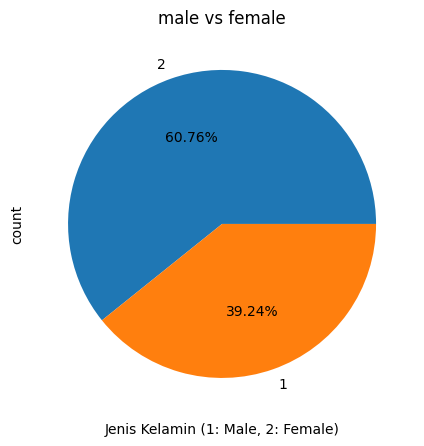

In [15]:
# membuat figure dan axis
fig,ax1 = plt.subplots(figsize=(5,5))

# plot data ke grafik
df['sex'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)

# menambahkan title
plt.title('male vs female')
plt.xlabel('Jenis Kelamin (1: Male, 2: Female)')

# menampilkan grafik
plt.show()

pengguna kartu kredit lebih banyak Female sebesar `60.76%` dan Male lebih sedikit sebesar `39.24%`.

## 2. Menampilkan age pengguna kartu kredit

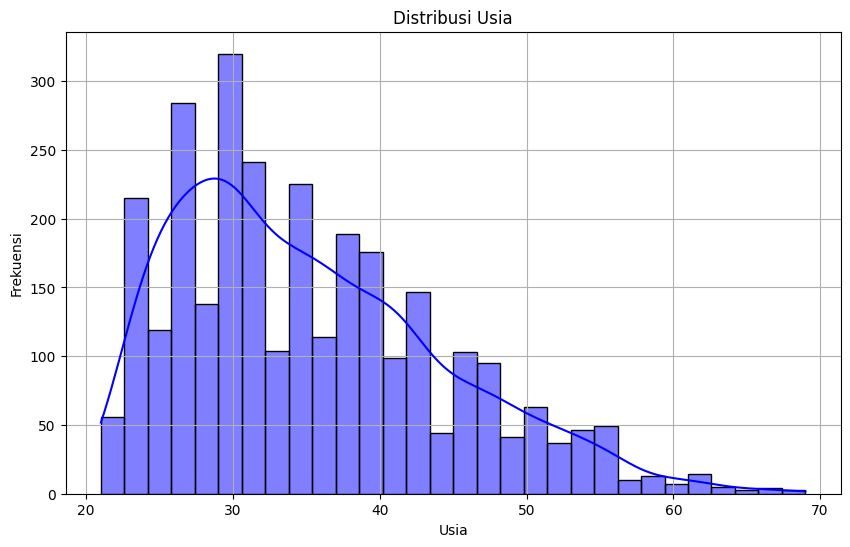

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', bins=30, kde=True, color='blue')
plt.title('Distribusi Usia')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

Umur pengguna berfariasi dari `21 tahun` sampai `69 tahun`. dengan umur paling banyak 30 tahun dan range umur paling banayk dari 20 akhir hingga 30 tahun awal.

## 3. Jumlah Pengguna kartu kredit berdasarkan martial status

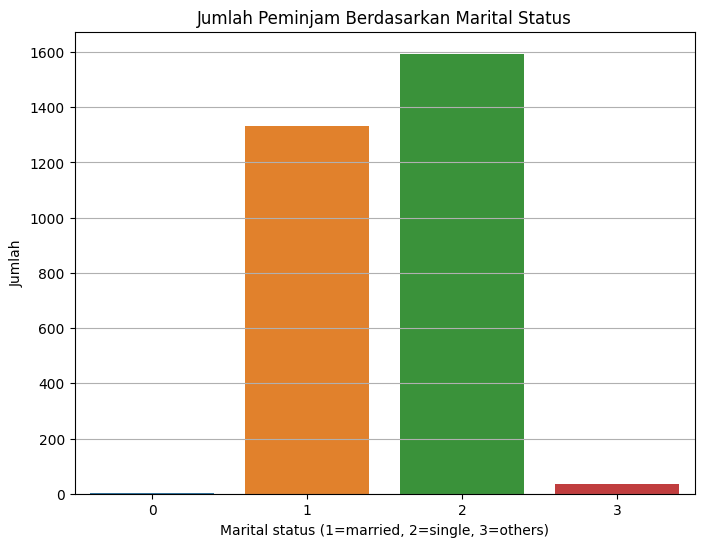

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='martial_status')
plt.title('Jumlah Peminjam Berdasarkan Marital Status')
plt.xlabel('Marital status (1=married, 2=single, 3=others)')
plt.ylabel('Jumlah')
plt.grid(axis='y')
plt.show()

Paling banyak pengguna kartu kredit adalah orang yang single mungkin karena belum banyak tanggungan hidup sehingga dapat bebas menggunakan kartu kredit untuk berbelanja ataupun liburan dan terbanyak selanjutnya adalah yang sudah menikah mungkin karena orang yang sudah menikah banyak membeli peralatan rumah tangga ataupun menyicil kendaraan atau alat lainnya lebih enak dan nyaman menggunakan kartu kredit. 

## 4. Jumlah pengguna kartu kredit berdasarkan educatoin level

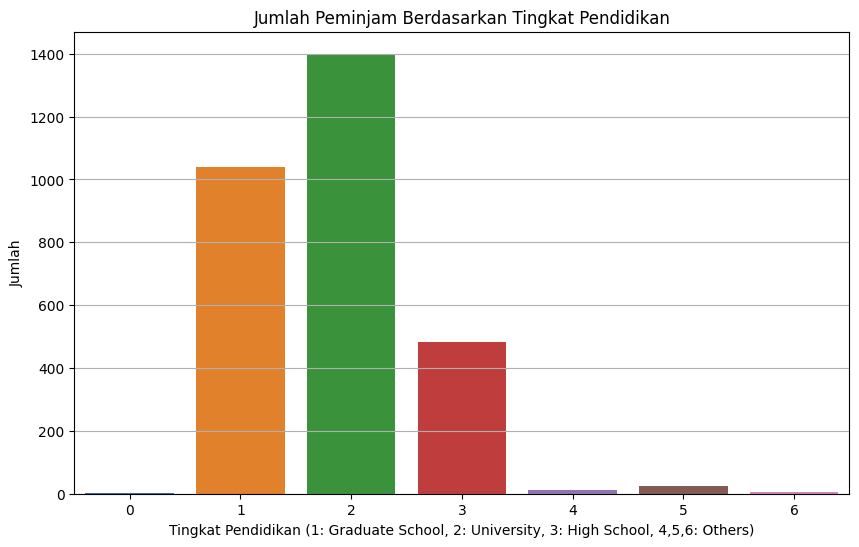

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='education_level')
plt.title('Jumlah Peminjam Berdasarkan Tingkat Pendidikan')
plt.xlabel('Tingkat Pendidikan (1: Graduate School, 2: University, 3: High School, 4,5,6: Others)')
plt.ylabel('Jumlah')
plt.grid(axis='y')
plt.show()

Paling banyak adalah yang tingkat pendidikannya university mungkin karena untuk membayar biaya kuliah yang tinggi jadi menggunakan kartu kredit agar bisa dicicil.

## 5. Menampilkan Status pelunasan

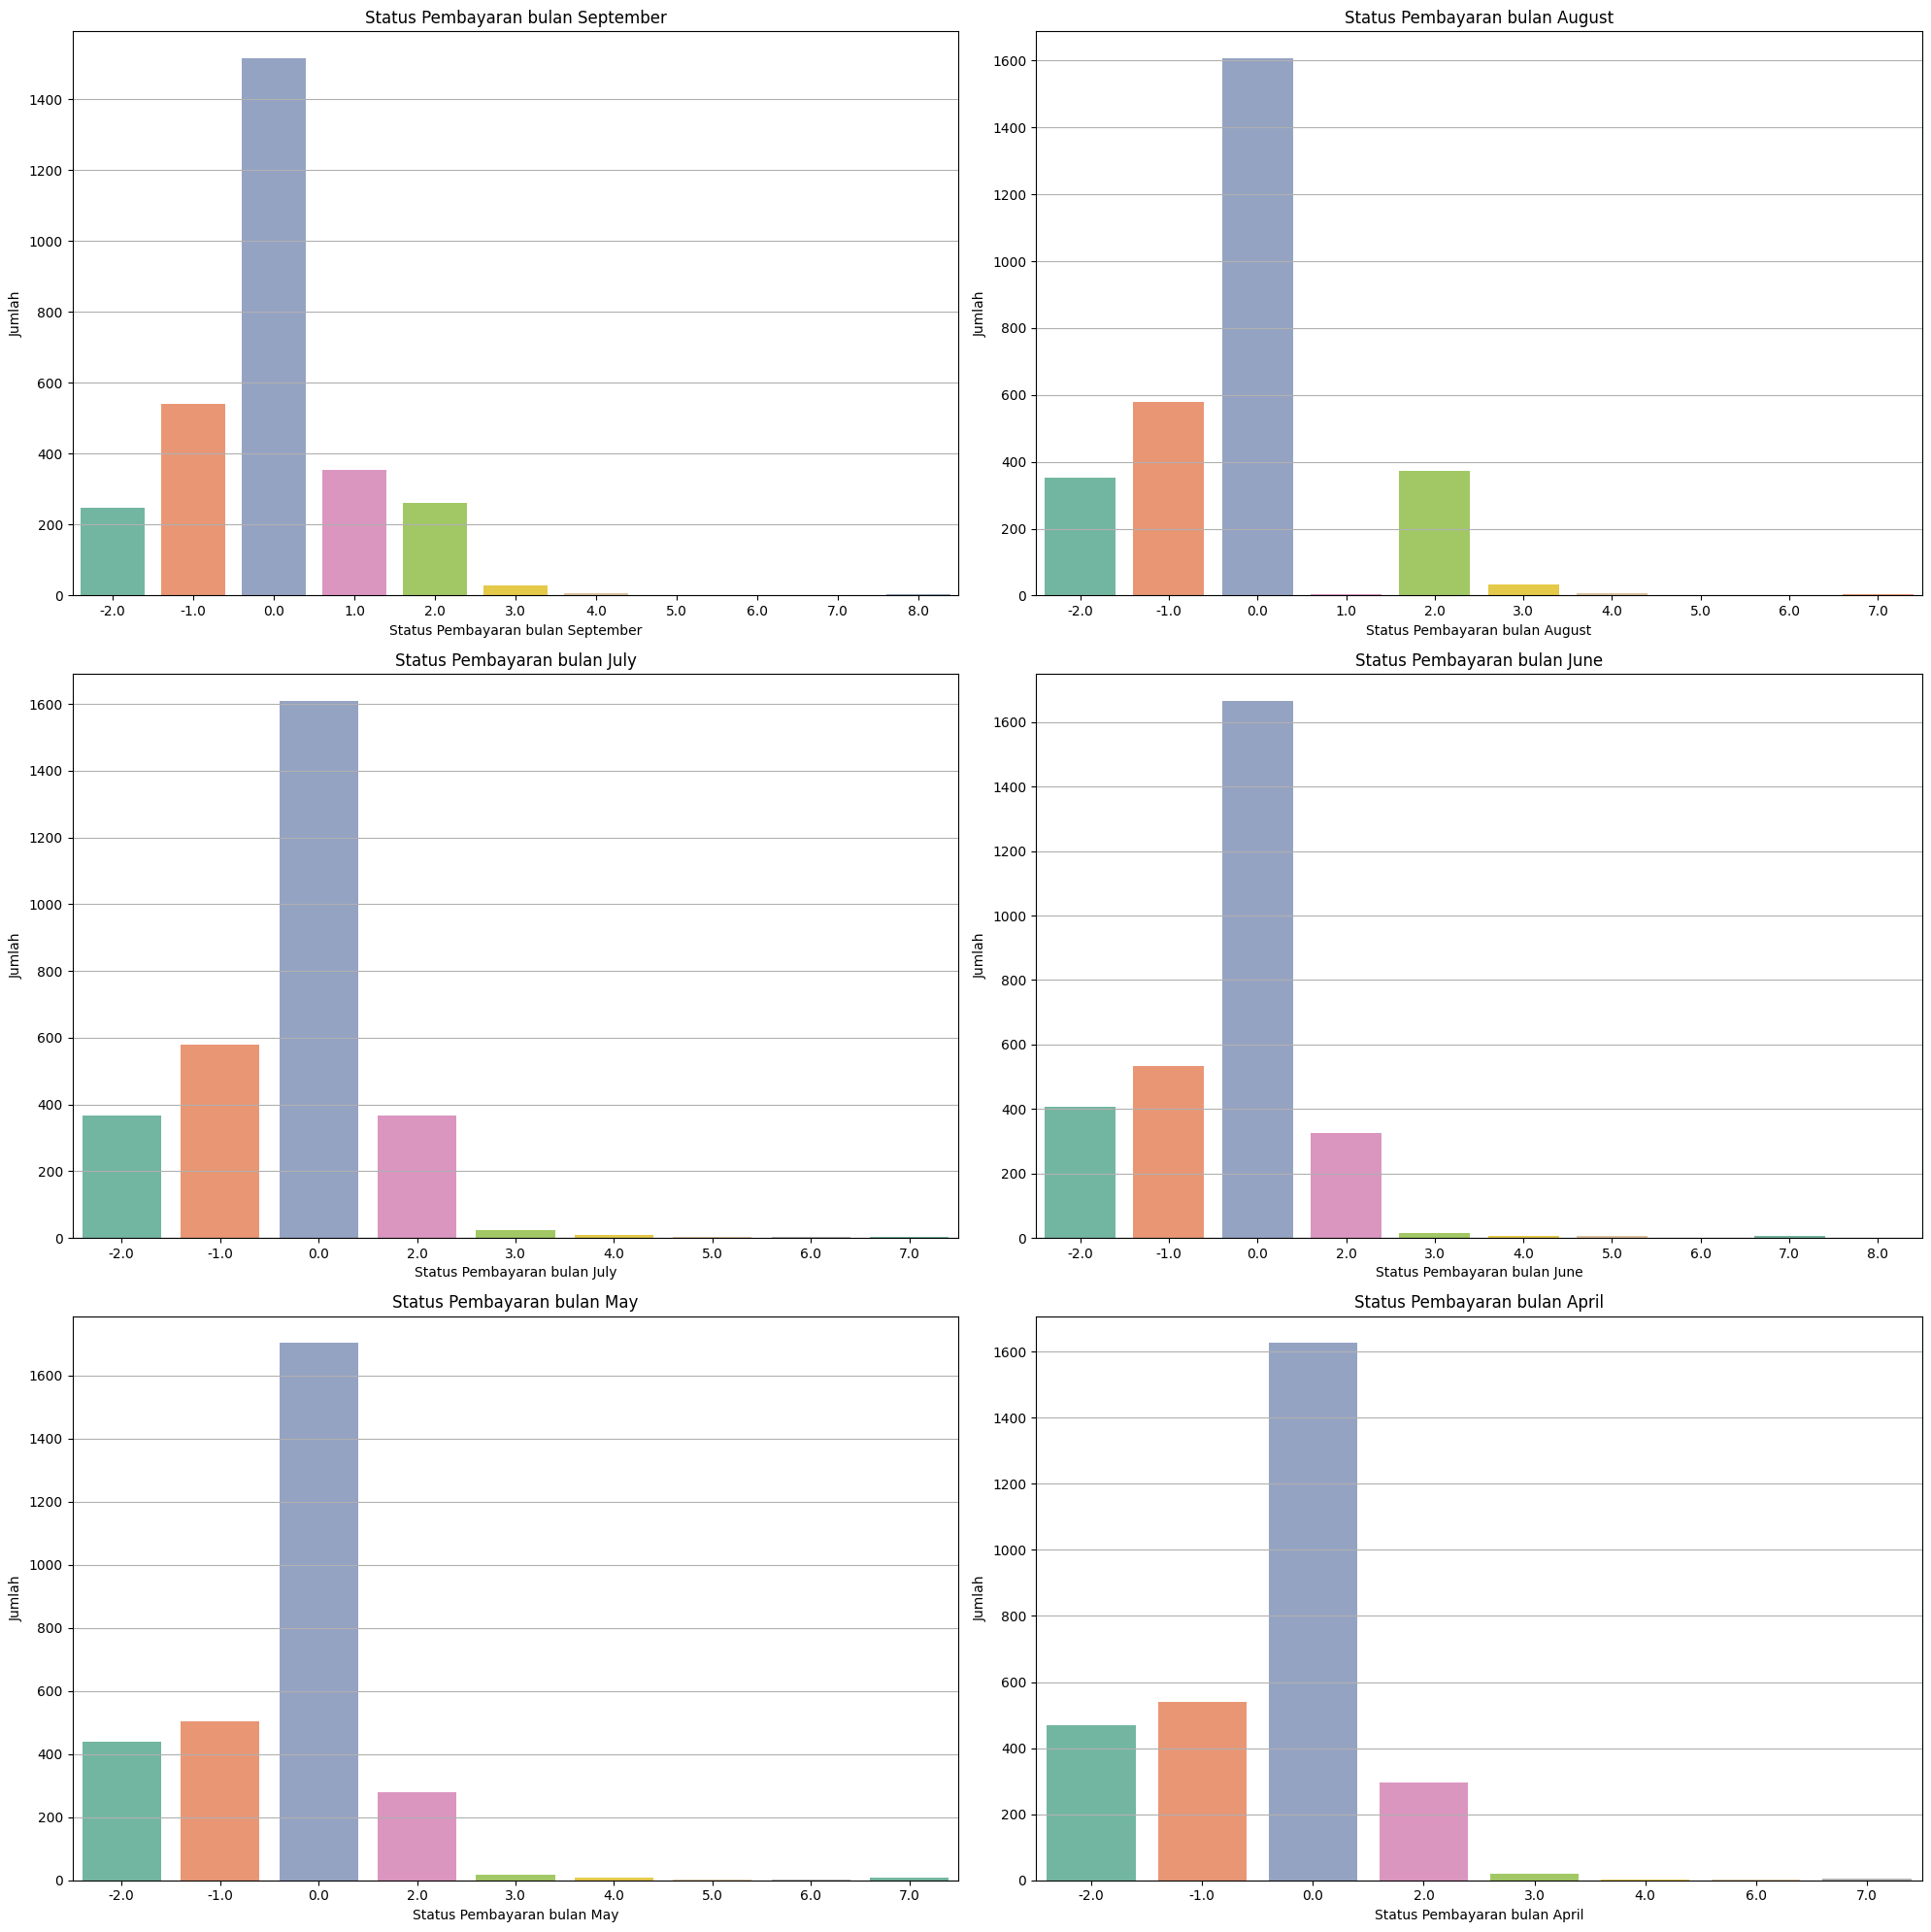

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

months = ['September', 'August', 'July', 'June', 'May', 'April']
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for ax, month, pay_col in zip(axes.flatten(), months, pay_cols):
    sns.countplot(data=df, x=pay_col, ax=ax, palette='Set2')
    ax.set_title(f'Status Pembayaran bulan {month}')
    ax.set_xlabel(f'Status Pembayaran bulan {month}')
    ax.set_ylabel('Jumlah')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

Dari data diatas dapat dilihat status pembayaran bulan september, agustus, juni, juli, mei. april. Dapat dilihat dari semua bulan kebanyakan orang membayar tepat waktu dari pada yang tidak tepat waktu. Dengan keterangan sebagai berikut

    -2: "pay more duly",
    -1: "pay duly",
    0: "payment delay",
    1: "payment delay for 1 month", 
    2: "payment delay for 2 months",
    3: "payment delay for 3 months",
    4: "payment delay for 4 months",
    5: "payment delay for 5 months",
    6: "payment delay for 6 months",
    7: "payment delay for 7 months",
    8: "payment delay for 8 months", 
    9: "payment delay for 9 months and above"

## 6. Menampilkan default payment next month

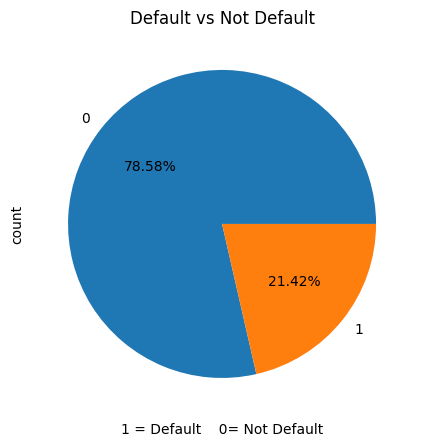

In [20]:
# membuat figure dan axis
fig,ax1 = plt.subplots(figsize=(5,5))

# plot data ke grafik
df['default_payment_next_month'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)

# menambahkan title
plt.title('Default vs Not Default')
plt.xlabel('1 = Default    0= Not Default')

# menampilkan grafik
plt.show()

Dari data diatas dapat dilihat lebih banyak yang tidak default(tidak membayara tagihan tepat waktu) sebanyak `78.58%` dari pada yang default sebanyak `21.42%`.

# vi. Feature Engineering

melakukan persiapan data untuk nantinya dibuat model

## Split dataset

### Inference-set

In [21]:
# menyimpan 1 data random dari data asli untuk digunakan sebagai data inference ke dalam variabel data_inf
data_inf = df.sample(1, random_state=0)

In [22]:
# Melihat data default_payment_next_monthnya berapa untuk nanti dibandingkan dengan model
data_inf['default_payment_next_month']

2337    0
Name: default_payment_next_month, dtype: int64

In [23]:
# menghapus data inference dari df
df.drop(data_inf.index, inplace=True)

# melakukan reset index untuk data_inf dan df
df.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

# menghapus target yaitu kolom 'default_payment_next_month' di data_inf
data_inf.drop(['default_payment_next_month'], axis=1, inplace=True)

# menyimpan dataset ke csv
data_inf.to_csv('data_tanpa_default_payment_next_month')

### Split between X (Features/Variables) and y (Target/Label)

In [24]:
# split between X(variabel) and y(target)

# kolom "default_payment_next_month" yang di drop karena kolom tersebut adalah target, disimpan di dalam variable X
X = df.drop(['default_payment_next_month'], axis=1)

# menyimpan tabel dengan kolom hanya default_payment_next_month kedalam variable y
y = df.default_payment_next_month

# menampilkan tabel X 
X.head()

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0


Split X_train, X_test, y_test, y_train

In [25]:
# splitting between Train and Test using train 'train_test_split()'ArithmeticError
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100) # stratify buat mempertahankan proporsi

# menampilkan jumlah baris dan kolom
print('X Train Size :' , X_train.shape)
print('X Test Size :' , X_test.shape)
print('y Train Size :' , y_train.shape)
print('y Test Size :' , y_test.shape)

X Train Size : (2370, 23)
X Test Size : (593, 23)
y Train Size : (2370,)
y Test Size : (593,)


## Missing value handling

sudah dicek saat data loading tidak ada missing value jadi tidak perlu handling misssing value

## Handling outliers

In [26]:
# menampilkan nama kolom
X_train.columns

Index(['limit_balance', 'sex', 'education_level', 'martial_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6'],
      dtype='object')

In [27]:
# menampilkan kolom yang hanya berisi integer dan float
num_col_1 = ['limit_balance','age', 'bill_amt_1', 'bill_amt_2',
       'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1',
       'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']

cat_col_1 = ['sex', 'education_level', 'martial_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

kolom yang di handling outliers hanya kolom num_col_1 karena handling outliers hanya meenghandling numerical kolom

In [28]:
# penampungan data
normal =[]
skew = []
extreme_skew = []

#membuat kondisi pengecekan skew data.
for i in num_col_1:
    skewness = X_train[i].skew()
    if -0.5 < skewness < 0.5:
        normal.append(i)
    elif -1 <= skewness <= -0.5 or 0.5 <= skewness <= 1:
        skew.append(i)
    elif skewness < -1 or skewness > 1:
        extreme_skew.append(i)

print('normal:',normal)
print('skew:',skew)
print('extreme_skew:',extreme_skew)

normal: []
skew: ['age']
extreme_skew: ['limit_balance', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


kolom yang skew : `'age'`  

kolom yang extreme skew: `'limit_balance'`, `'bill_amt_1'`, `'bill_amt_2'`, `'bill_amt_3'`, `'bill_amt_4'`, `'bill_amt_5'`, `'bill_amt_6'`, `'pay_amt_1'`, `'pay_amt_2'`, `'pay_amt_3'`, `'pay_amt_4'`, `'pay_amt_5'`, `'pay_amt_6'`

In [29]:
# Capping the skewed distribution
winsoriser_skew = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5, ## karena skew
                             variables=skew)

winsoriser_extreme_skew = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3, ## karena extreme
                             variables=extreme_skew)

In [30]:
# menggunakan winsorizer untuk mengatasi outlier pada Xtrain
X_train_cap = winsoriser_skew.fit_transform(X_train)

X_train_cap = winsoriser_extreme_skew.fit_transform(X_train)

menggunakan winsorizer karena saya tidak ingin membuang data saya dan karena setiap data berharga sehingga lebih baik direduce outliersnya

In [31]:
# function
def find_skewed_boundaries(X_train, variable, distance):
    IQR = X_train[variable].quantile(0.75) - X_train[variable].quantile(0.25)
    lower_boundary = X_train[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = X_train[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

def calculate_outliers_percentage(X_train, variable, distance):    
    upper_boundary, lower_boundary = find_skewed_boundaries(X_train, variable, distance)
    outliers = X_train[(X_train[variable] < lower_boundary) | (X_train[variable] > upper_boundary)]
    per = (len(outliers) / len(X_train)) * 100
    print('Percentage of outliers in {}: {:.2f}%'.format(variable, per))

### mengecek % outliers sebelum di handling outlier

In [32]:
def find_skewed_boundaries(X_train, variable, distance):
    IQR = X_train[variable].quantile(0.75) - X_train[variable].quantile(0.25)
    lower_boundary = X_train[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = X_train[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

def calculate_outliers_percentage(X_train, variable, distance):    
    upper_boundary, lower_boundary = find_skewed_boundaries(X_train, variable, distance)
    outliers = X_train[(X_train[variable] < lower_boundary) | (X_train[variable] > upper_boundary)]
    per = (len(outliers) / len(X_train)) * 100
    print('Percentage of outliers in {}: {:.2f}%'.format(variable, per))

# Loop through each column in X_train
for col in skew:
    calculate_outliers_percentage(X_train, col, 1.5)

for col in extreme_skew:
    calculate_outliers_percentage(X_train, col, 3)

Percentage of outliers in age: 0.89%
Percentage of outliers in limit_balance: 0.08%
Percentage of outliers in bill_amt_1: 2.83%
Percentage of outliers in bill_amt_2: 2.62%
Percentage of outliers in bill_amt_3: 2.83%
Percentage of outliers in bill_amt_4: 2.66%
Percentage of outliers in bill_amt_5: 2.66%
Percentage of outliers in bill_amt_6: 2.36%
Percentage of outliers in pay_amt_1: 5.23%
Percentage of outliers in pay_amt_2: 6.16%
Percentage of outliers in pay_amt_3: 5.40%
Percentage of outliers in pay_amt_4: 4.60%
Percentage of outliers in pay_amt_5: 4.85%
Percentage of outliers in pay_amt_6: 5.57%


### mengecek % outliers setelah di handling outlier

In [33]:
for col in skew:
    calculate_outliers_percentage(X_train_cap, col, 1.5)

for col in extreme_skew:
    calculate_outliers_percentage(X_train_cap, col, 3)

Percentage of outliers in age: 0.89%
Percentage of outliers in limit_balance: 0.00%
Percentage of outliers in bill_amt_1: 0.00%
Percentage of outliers in bill_amt_2: 0.00%
Percentage of outliers in bill_amt_3: 0.00%
Percentage of outliers in bill_amt_4: 0.00%
Percentage of outliers in bill_amt_5: 0.00%
Percentage of outliers in bill_amt_6: 0.00%
Percentage of outliers in pay_amt_1: 0.00%
Percentage of outliers in pay_amt_2: 0.00%
Percentage of outliers in pay_amt_3: 0.00%
Percentage of outliers in pay_amt_4: 0.00%
Percentage of outliers in pay_amt_5: 0.00%
Percentage of outliers in pay_amt_6: 0.00%


outliers pada extreme skew menjadi 0 teteapi pada skew tidak karena outliers pada skew tida kterlalu berpengaruh sehingga tidak berkurang % outliersnya

## Feature Selection

In [34]:
# show X_train
X_train.head()

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
317,100000.0,2,1,2,28.0,0.0,0.0,0.0,2.0,0.0,...,14479.0,10775.0,10998.0,12655.0,1300.0,3005.0,0.0,700.0,2000.0,1500.0
2117,20000.0,1,2,1,58.0,-1.0,-1.0,2.0,2.0,-1.0,...,200.0,0.0,28740.0,1295.0,21654.0,0.0,0.0,28740.0,1565.0,0.0
179,180000.0,2,1,2,27.0,0.0,0.0,0.0,0.0,0.0,...,98186.0,59451.0,49956.0,50133.0,5000.0,3371.0,6940.0,2800.0,2000.0,2000.0
104,500000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,113409.0,114191.0,117285.0,120388.0,5000.0,5571.0,4152.0,5000.0,5000.0,5000.0
1998,220000.0,2,1,1,41.0,7.0,6.0,5.0,4.0,3.0,...,232446.0,227800.0,225044.0,222356.0,0.0,0.0,0.0,0.0,0.0,6000.0


In [35]:
# menampilkan anam kolom
X_train.columns

Index(['limit_balance', 'sex', 'education_level', 'martial_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6'],
      dtype='object')

In [36]:
# membagi nama kolom

set1 = ['limit_balance', 'sex', 'education_level', 'martial_status', 'age']

set2 = ['pay_0', 'pay_2','pay_3', 'pay_4', 'pay_5', 'pay_6']

set3 = ['bill_amt_1', 'bill_amt_2','bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6']

set4 = ['pay_amt_1','pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


### Phik

In [37]:
# Concat columns
concat_train1 = pd.concat([ y_train, X_train_cap[set1]],axis=1)
concat_train1.phik_matrix()['default_payment_next_month']

interval columns not set, guessing: ['default_payment_next_month', 'limit_balance', 'sex', 'education_level', 'martial_status', 'age']


default_payment_next_month    1.000000
limit_balance                 0.190664
sex                           0.014988
education_level               0.074727
martial_status                0.000000
age                           0.041128
Name: default_payment_next_month, dtype: float64

In [38]:
# Concat columns
concat_train2 = pd.concat([y_train, X_train_cap[set2]],axis=1)
concat_train2.phik_matrix()['default_payment_next_month']

interval columns not set, guessing: ['default_payment_next_month', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


default_payment_next_month    1.000000
pay_0                         0.583947
pay_2                         0.457705
pay_3                         0.331365
pay_4                         0.319234
pay_5                         0.319019
pay_6                         0.384994
Name: default_payment_next_month, dtype: float64

In [39]:
# Concat columns
concat_train3 = pd.concat([y_train, X_train_cap[set3]],axis=1)
concat_train3.phik_matrix()['default_payment_next_month']

interval columns not set, guessing: ['default_payment_next_month', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6']


default_payment_next_month    1.000000
bill_amt_1                    0.012017
bill_amt_2                    0.043210
bill_amt_3                    0.054394
bill_amt_4                    0.046538
bill_amt_5                    0.012981
bill_amt_6                    0.000000
Name: default_payment_next_month, dtype: float64

In [40]:
# Concat columns
concat_train4 = pd.concat([y_train, X_train_cap[set4]],axis=1)
concat_train4.phik_matrix()['default_payment_next_month']

interval columns not set, guessing: ['default_payment_next_month', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


default_payment_next_month    1.000000
pay_amt_1                     0.160649
pay_amt_2                     0.180610
pay_amt_3                     0.143120
pay_amt_4                     0.118075
pay_amt_5                     0.150472
pay_amt_6                     0.166935
Name: default_payment_next_month, dtype: float64

### mengdrop kolom yang tidak ada korelasinya dan korelasi dibawah `0.3` sehingga tidak diperlukan.

In [41]:
# drop kolom 
X_train_cap.drop(['limit_balance','sex', 'education_level', 'martial_status', 'age','bill_amt_1', 'bill_amt_2',
       'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1',
       'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], axis=1, inplace=True)

X_test.drop(['limit_balance','sex', 'education_level', 'martial_status', 'age','bill_amt_1', 'bill_amt_2',
       'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1',
       'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], axis=1, inplace=True)

In [42]:
# menampilkan nama kolom
# untuk mengecek hasil penghapusan kolom yang tidak berkorelasi
print('X Train Columns :' , X_train_cap.columns)
print('y Train Columns :' , X_test.columns)   

X Train Columns : Index(['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], dtype='object')
y Train Columns : Index(['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], dtype='object')


In [43]:
X_train_cap.nunique()

pay_0    10
pay_2    10
pay_3     9
pay_4    10
pay_5     9
pay_6     8
dtype: int64

In [44]:
X_train['pay_0'].unique()

array([ 0., -1.,  7.,  1.,  2., -2.,  3.,  4.,  8.,  5.])

## Split between Numerical dan Categorical Column

In [45]:
# split numerical dan  categorical kolom
cat_ordinal_col = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

print(f'categorical columns: {cat_ordinal_col}')

categorical columns: ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


In [46]:
# split train test based on column types
X_train_cat = X_train_cap[cat_ordinal_col]
X_test_cat = X_test[cat_ordinal_col]

X_train_cat.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
317,0.0,0.0,0.0,2.0,0.0,0.0
2117,-1.0,-1.0,2.0,2.0,-1.0,-1.0
179,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0,0.0,0.0
1998,7.0,6.0,5.0,4.0,3.0,2.0


## Cardinality check for categorical columns

mengelompokkan valuenya menjadi beberapa kelompok

In [47]:
X_train_cat.nunique()

pay_0    10
pay_2    10
pay_3     9
pay_4    10
pay_5     9
pay_6     8
dtype: int64

karena unik valuenya sedikti jadi tidak perlu di cardinality check

## Feature Scaling

mengscale numerical kolom value yang bervariasi menjadi seragam yaitu dengan range 0 sampai 1

karena kolom yang dipilih tidak ada yang numerical jadi tidak perlu melakukan feature scaling

## Feature Encoding

Mengubah huruf menjadi angka agar dapat terbaca oleh sistem

tidak dilakukan karena kolom merupakan categorical encoded

## Concate between numerical and categorical columns

menggabungkan kolom numerical yang sudah di scale dan kolom categorical yang sudah di encoded

Tidak diperlukan karena hanya ada kolom categorical encoded

# vii. Model Definition

setelah feature engineering selesai melakukan model definition

In [48]:
# mempersiapkan data
preprocess = ColumnTransformer(
    transformers=[
    ],
    remainder='passthrough'
)

In [49]:
# Create pipline for each model
pipe_log = make_pipeline(preprocess, LogisticRegression())
pipe_svc = make_pipeline(preprocess, SVC())
pipe_knn = make_pipeline(preprocess, KNeighborsClassifier())

# viii. Model Training

In [50]:
# Define cross val for each pipe_model
cv_log = cross_val_score(pipe_log, X_train_cat, y_train, cv=3, scoring='f1', n_jobs=-1)
cv_svc = cross_val_score(pipe_svc, X_train_cat, y_train, cv=3, scoring='f1', n_jobs=-1)
cv_knn = cross_val_score(pipe_knn, X_train_cat, y_train, cv=3, scoring='f1', n_jobs=-1)

menggunakan `F1 Score` karena ingin memengecikjan false positive dan false negative secara bersamaan

# ix. Model Evaluation

setelah melakukan model training selanjutnya melakukan model evaluation

## find best model from `log`, `svc`, `knn`

In [51]:
# Finding Best Model based on Cross_Val_Score (mean)
name_model = []
cv_score = 0
for cv,name in zip([cv_log,cv_svc,cv_knn],
                   ['log','svc','dt','rf','knn','nb','ada']):
    print(name)
    print('f1 score - All - Cross Validation', cv)
    print('f1 score - mean - Cross Validation', cv.mean())
    print('f1 score - std - Cross Validation', cv.std())
    print('f1 score - range - Cross Validation', (cv.mean()-cv.std()), '-', (cv.mean() + cv.std()))
    print('-'*50)
    if cv.mean() > cv_score:
        cv_score = cv.mean()
        name_model = name
    else:
        pass

print('Best Model:', name_model)
print('Cross Val Mean from Best Model:', cv_score)

log
f1 score - All - Cross Validation [0.406639   0.32075472 0.38181818]
f1 score - mean - Cross Validation 0.3697373009828972
f1 score - std - Cross Validation 0.03608774913934716
f1 score - range - Cross Validation 0.33364955184355005 - 0.40582505012224435
--------------------------------------------------
svc
f1 score - All - Cross Validation [0.50896057 0.47104247 0.49070632]
f1 score - mean - Cross Validation 0.49023645474059196
f1 score - std - Cross Validation 0.015483565542538146
f1 score - range - Cross Validation 0.4747528891980538 - 0.5057200202831301
--------------------------------------------------
dt
f1 score - All - Cross Validation [0.49097473 0.433213   0.46808511]
f1 score - mean - Cross Validation 0.4640909440049159
f1 score - std - Cross Validation 0.023749658879554266
f1 score - range - Cross Validation 0.44034128512536164 - 0.4878406028844702
--------------------------------------------------
Best Model: svc
Cross Val Mean from Best Model: 0.49023645474059196


Didapat best model adalah `SVC` dengan cross val mean `0.49`

In [52]:
pipe_svc.fit(X_train_cat,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('svc', SVC())])

## Support Vector Machine (SVM)

### Predict train dan test set menggunakan `SVC`

In [53]:
pipe_svc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('svc', SVC())])

In [54]:
# Create a function to check the performance

def performance_check(clf, X, y):
  y_pred = clf.predict(X)

  return f1_score(y, y_pred)

In [55]:
pipe_svc.fit(X_train_cat, y_train)

# Check model performance
print('f1 - Train : ', performance_check(pipe_svc, X_train_cat, y_train))
print('f1 - Test  : ', performance_check(pipe_svc, X_test_cat, y_test))

f1 - Train :  0.530359355638166
f1 - Test  :  0.5544554455445545


f1 score pada data train menggunakan svc adalah 0.53 dan f1 score pada data test adalah 0.55. Walaupun `test > train` seharusnya goodfit, tetapi `train < 80%` artinya model `underfit`.

## confusion matrix

F1 Score - Train Set  :  0.530359355638166 

F1 Score - test Set  :  0.5544554455445545 

Confusion Matrix Train Set: 
Confusion Matrix Test Set : 


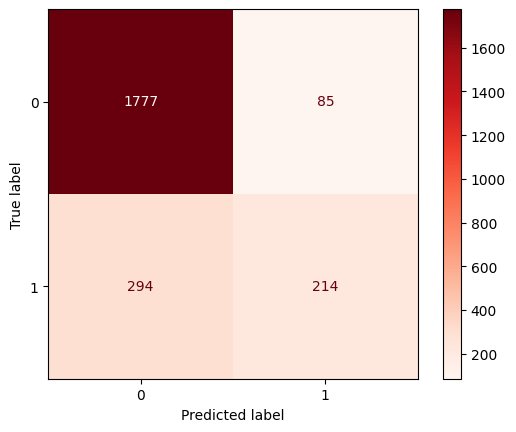

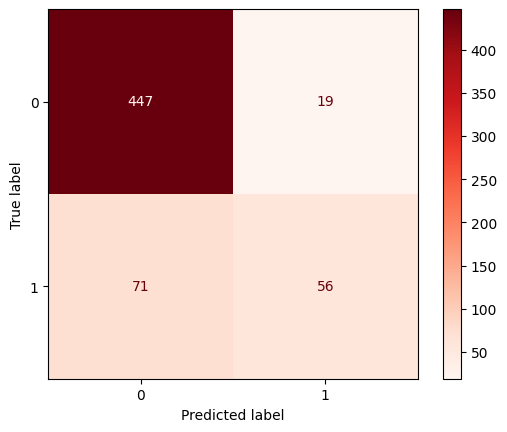

In [56]:
# Check Performance Model against Train-Set

y_pred_train = pipe_svc.predict(X_train_cat)
y_pred_test = pipe_svc.predict(X_test_cat)

print('F1 Score - Train Set  : ', f1_score(y_train, y_pred_train), '\n')
print('F1 Score - test Set  : ', f1_score(y_test, y_pred_test), '\n')

print('Confusion Matrix Train Set: \n', ConfusionMatrixDisplay.from_estimator(pipe_svc, X_train_cat, y_train, cmap='Reds'))
print('Confusion Matrix Test Set : \n', ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test_cat, y_test, cmap='Reds'))

In [57]:
# Save Classification Report into a Dictionary

all_reports = {}
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
  score_reports = {
      'train - f1_score' : f1_score(y_train, y_pred_train),
      'test - f1_score' : f1_score(y_test, y_pred_test),
  }
  all_reports[name] = score_reports
  return all_reports

all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'Baseline (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter)
train - f1_score,0.530359
test - f1_score,0.554455


## tuning best model untuk cari best parameternya

In [58]:
# Daftar hyperparameter yang akan dioptimalkan
param_grid = {
    'svc__C': [1,2,3,4,5,6,7,8,9,10],
    'svc__kernel': ['linear','rbf', 'sigmoid'],
    'svc__gamma': ['scaled','auto']
}

# Inisialisasi GridSearchCV untuk pencarian parameter terbaik
grid_search = GridSearchCV(pipe_svc, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Lakukan grid search untuk mencari kombinasi parameter terbaik
grid_search.fit(X_train_cat, y_train)

# Dapatkan parameter terbaik setelah grid search selesai
best_params = grid_search.best_params_
print("Best Parameter:")
print(best_params)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameter:
{'svc__C': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}


didapat best parameternya  c = 2, gamma = auto, kerel = rbf

F1 Score for Train Set: 0.551980198019802 

F1 Score for Test Set: 0.5728155339805825 

Confusion Matrix      : 
Confusion Matrix      : 


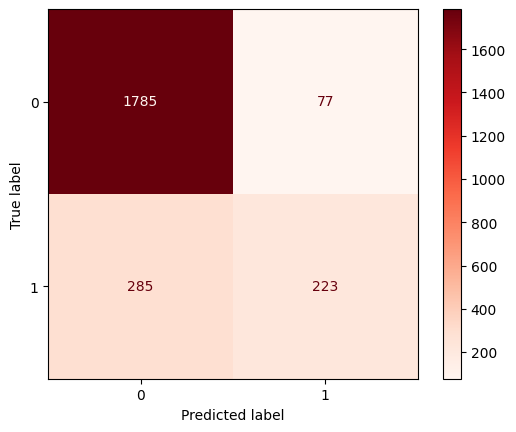

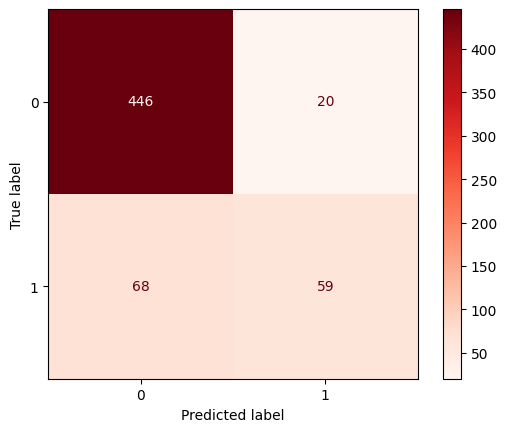

In [59]:
# Menggunakan model terbaik dari GridSearchCV
best_svc = grid_search.best_estimator_

# Memprediksi kelas untuk data pelatihan dan data uji
y_train_pred_tuned = best_svc.predict(X_train_cat)
y_test_pred_tuned = best_svc.predict(X_test_cat)

# Menghitung skor F1 untuk data pelatihan dan data uji
f1_train = f1_score(y_train, y_train_pred_tuned)
f1_test = f1_score(y_test, y_test_pred_tuned)

# Menampilkan skor F1
print("F1 Score for Train Set:", f1_train, '\n')
print("F1 Score for Test Set:", f1_test, '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_svc, X_train_cat, y_train, cmap='Reds'))
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_svc, X_test_cat, y_test, cmap='Reds'))

In [60]:
# menampilkan f1 score sebelum dan setelah tunning 
all_reports = performance_report(all_reports, y_train, y_train_pred_tuned, y_test, y_test_pred_tuned, 'Grid Search')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),Grid Search
train - f1_score,0.530359,0.551980
test - f1_score,0.554455,0.572816


f1 score after tuning lebih baik daripada before tuning dari train 0.53 menjadi 0.55 dan test dari 0.55 menjadi 0.57. Setelah tuning f1 score pada data train dan test naik, tetapi masih `underfit` karena masih kurang dari 80% walaupun test>train.

# x. Model Saving

setelah selesai model training, evaluation, dan saving selanjutnya adalah save model agar nanti dapat dibuat.

In [61]:
with open('best_model.pkl','wb') as file_1: # wb = write binary
    pickle.dump(best_svc,file_1)

# xi. Model Inference

tujuan : Untuk menjaga data tetap confidential.
disimpan di notebook berbeda

# xii. Pengambilan Kesimpulan

> matric:

menggunakan metrik F1 score karena ingin memengecikjan false positive dan false negative secara bersamaan.
dari hasil evaluasi model Support Vector Classifier (SVC) memiliki nilai F1-score tertinggi rata-rata dari ketiga model yang dievaluasi, yaitu sebesar 0.49. Hal ini menunjukkan bahwa SVC memiliki keseimbangan yang baik antara presisi dan recall dalam memprediksi default payment pada pengguna kartu kredit.


>EDA:   
- pengguna kartu kredit lebih banyak Female sebesar `60.76%` dan Male lebih sedikit sebesar `39.24%`.  
- Umur pengguna berfariasi dari `21 tahun` sampai `69 tahun`. dengan umur paling banyak 30 tahun dan range umur paling banayk dari 20 akhir hingga 30 tahun awal.  
- Paling banyak pengguna kartu kredit adalah orang yang single mungkin karena belum banyak tanggungan hidup sehingga dapat bebas menggunakan kartu kredit untuk berbelanja ataupun liburan dan terbanyak selanjutnya adalah yang sudah menikah mungkin karena orang yang sudah menikah banyak membeli peralatan rumah tangga ataupun menyicil kendaraan atau alat lainnya lebih enak dan nyaman menggunakan kartu kredit.   
- Paling banyak adalah yang tingkat pendidikannya university mungkin karena untuk membayar biaya kuliah yang tinggi jadi menggunakan kartu kredit agar bisa dicicil.  
- Dari data diatas dapat dilihat status pembayaran bulan september, agustus, juni, juli, mei. april. Dapat dilihat dari semua bulan kebanyakan orang membayar tepat waktu dari pada yang tidak tepat waktu.  
- Dari data diatas dapat dilihat lebih banyak yang tidak default(tidak membayara tagihan tepat waktu) sebanyak `78.58%` dari pada yang default sebanyak `21.42%`.


kelebihan dan kekurangan svn:  
`kelebihan`
- ketika jumlah fiturnya banyak tapi sampelnya dikit (makin banyak rownya makin lama tapi makin banyak kolom gak masalah)
- cocok untuk data kecil
- bisa buat data non linear (kebanyakan data itu non linear)

`kekurangan`  
- tidak cocok untuk datanya besar (trainingnya lama dan makan meori)



>Dari data dapat di beri bisnis insighgt sebagai berikut:    
- lebih menawarkan kredit card kepada orang-orang yang single karena lebih banyak ketertarikan mereka memakai
- memutus atau menghentikan customer yang menunggak terlalu lama dan mengihnya
- mendatangin university untuk mempromosikan creditcar karena banyak anak university yang memakainya

> untuk imporvement:  
- mengambil data lebih banyak
- mencoba model dan parameter lebih banyak
- mencoba mencari parameter terbaik dengan random search (mungkin hasilnya berbeda)
- dari saran diatas diharapkan dapat meningkatkan model yang underfit menjadi goodfit.